In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time
import sympy
np.set_printoptions(precision=3)

In [2]:
## Setup a model params

M = 2                # the population has two age groups
N = 5e4              # and this is the total population
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi
# set the contact structure
C = np.array([[18., 9.], 
              [3., 12.]]) 
def contactMatrix(t):
    return C

t2 = 20 
Nf = t2 + 1 

time_points=np.linspace(0, t2, Nf)
dt = time_points[1]-time_points[0]

## Inital From Gunther
alpha = 0.20952031
beta = 0.02008036 
gIa =0.14791327  
gIs = 0.14231912
fsa = 1

x0 = np.array([*(Ni-2), 10, 10, 10, 10])
print(x0)


### Set up model spec
inference_parameters = {
    'betaIa' : beta*alpha, 
    'betaIs' : beta*(1-alpha), 
    'gIa' : gIa, 
    'gIs' : gIs
}
model_spec = {
    "classes" : ["S", "Ia", "Is"],

    "S" : {
        "linear"    : [],
        "infection" : [ ["Ia", "-betaIa"], ["Is", "-betaIa"], ["Ia", "-betaIs"], ["Is", "-betaIs"]]
    },
    "Ia" : {
        "linear"    : [ ["Ia", "-gIa"] ],
        "infection" : [ ["Ia", "betaIa"], ["Is", "betaIa"] ]
    }, 
    "Is" :{
        "linear"    : [ ["Is", "-gIs"] ],
        "infection" : [ ["Is", "betaIs"], ["Ia", "betaIs"]]
    }
}


[1.25e+04 3.75e+04 1.00e+01 1.00e+01 1.00e+01 1.00e+01]


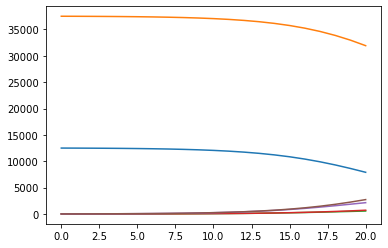

In [3]:
# initialise the estimator 
nClass = len(model_spec['classes'])
nParams = len(inference_parameters)
estimator = pyross.inference.Spp(model_spec, inference_parameters, M, Ni)
estimator.set_det_model(inference_parameters)
estimator.set_contact_matrix(contactMatrix)

xm, sol = estimator.integrate(x0, 0, t2, Nf, dense_output=True)
plt.plot(xm)
plt.show() 

## Tests of the gradient computations

0.004250764846801758
(21, 6, 6)


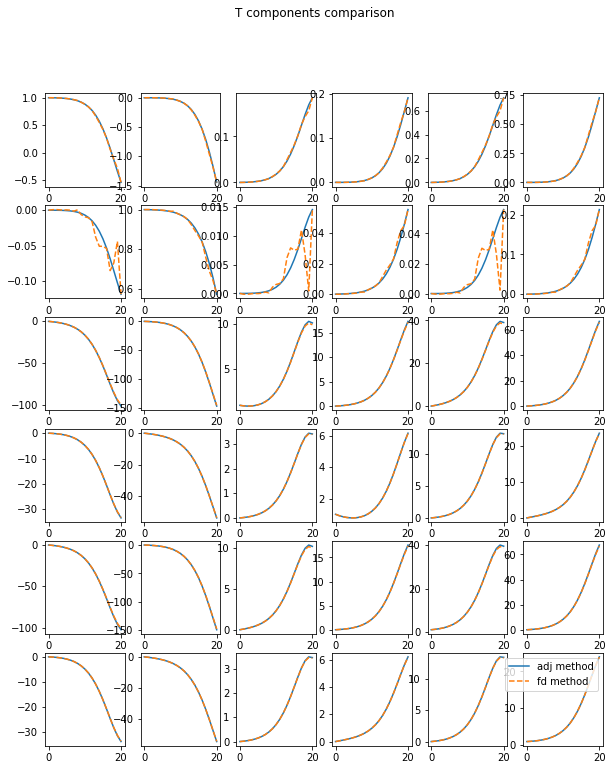

In [5]:
##################### TEST 1 : Time evol Op ####################################
estimator.set_lyapunov_method('LSODA')

T1 = np.zeros((Nf, M*nClass, M*nClass))
T2 = np.zeros((Nf, M*nClass, M*nClass))
T2[0,:,:] = np.identity(M*nClass)
for k,ts in enumerate(time_points[1:]):
    estimator._obtain_time_evol_op_2(sol, 0, ts)
    T2[k+1,:,:] = estimator.U.T

dx0 = np.identity((M*nClass))
start_time = time.time() 
T1 = estimator.dmudx0(sol, t2, Nf, dx0)
end_time = time.time() 
print(end_time-start_time)
print(T1.shape)

fig, axs = plt.subplots(M*nClass,M*nClass, figsize=(10, 12))
axs = np.ndarray.flatten(axs)
for k,ax in enumerate(axs):
    kx = k //(M*nClass)
    ky = k % (M*nClass)
    ax.plot(T1[:,kx,ky], label="adj method")
    ax.plot(T2[:,kx,ky], '--', label="fd method")
plt.suptitle("T components comparison")
plt.legend()
plt.show()

In [4]:
################## TEST 3 : Derivatives of mean trajectories ################################
## NOTE: this is a bit slow
est_obj = pyross.inference.Spp(model_spec, inference_parameters, M, Ni)
est_obj.set_contact_matrix(contactMatrix)

def dtrajdp_FD(param_str, scale=1e5):
    """ Calculates deribvative of mean traj using finite difference (FD)"""
    Paramvalue = inference_parameters[param_str]
    dp = Paramvalue/scale

    inference_parameters[param_str] +=dp
    est_obj.set_params(inference_parameters)
    est_obj.set_det_model(inference_parameters)
    xd_p = est_obj.integrate(x0, 0, t2, Nf) 
    
    inference_parameters[param_str] -= 2*dp
    est_obj.set_params(inference_parameters)
    est_obj.set_det_model(inference_parameters)
    xd_m = est_obj.integrate(x0, 0, t2, Nf)

    inference_parameters[param_str] +=dp
    return xd_p, xd_m, dp

In [5]:
keys = np.ones((nParams,M), dtype=int)
estimator.set_det_model(inference_parameters)
nSamples=Nf
nBlock=1
dp = np.ones((1, 2))

_, sol = estimator.integrate(x0, 0, t2, Nf, dense_output=True)
estimator.lambdify_derivative_functions(['betaIa'])
dtraj = estimator.dmudp(sol, t2, nSamples, dp)
print(dtraj.shape)

Looking for saved derivative functions...
Loaded.
(21, 1, 6)


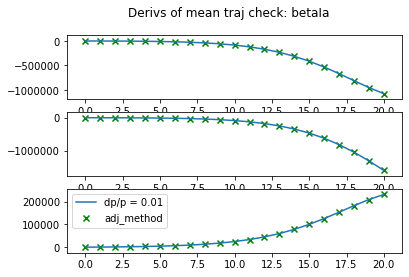

In [6]:
## Find derivatives wrt the params via finite difference
scale=1e2
xp, xm, dp = dtrajdp_FD('betaIa', scale=scale)
dxdp=(xp-xm)/(2*dp)

fig, axs = plt.subplots(nClass)
axs = np.ndarray.flatten(axs)
for k, axx in enumerate(axs):
    axx.plot(time_points, dxdp[:,k], label=f"dp/p = {1/scale}")
    axx.scatter(time_points[::nBlock], dtraj[:, 0, k], marker='x', color='green', label=f"adj_method")
plt.suptitle("Derivs of mean traj check: betaIa")
plt.legend()
plt.show()

Looking for saved derivative functions...
Loaded.
0.07233285903930664


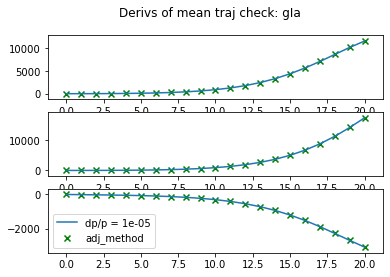

In [7]:
## Find derivatives wrt the params via finite difference
scale=1e5
xp, xm, dp = dtrajdp_FD('gIa', scale=scale)
dxdp=(xp-xm)/(2*dp)


estimator.lambdify_derivative_functions(['gIa'])

start_time = time.time() 
dp = np.ones((1, 2))
dtraj = estimator.dmudp(sol, t2, nSamples, dp, rtol=1e-4)
end_time = time.time() 
print(end_time-start_time)

fig, axs = plt.subplots(nClass)
axs = np.ndarray.flatten(axs)
for k, axx in enumerate(axs):
    axx.plot(time_points, dxdp[:,k], label=f"dp/p = {1/scale}")
    axx.scatter(time_points[::nBlock], dtraj[:, 0, k], marker='x', color='green', label=f"adj_method")
plt.suptitle("Derivs of mean traj check: gIa")
plt.legend()
plt.show()

## Checking derivatives of covariance 

In [25]:
nSamples = Nf
init_fltr = np.ones((M*nClass), dtype=bool)
estimator.set_params(inference_parameters)
estimator.set_det_model(inference_parameters)
estimator.lambdify_derivative_functions(['betaIa'])
dp = np.ones((1, 2))
dx0 = np.identity((M*nClass))[[0], :]
start_time = time.time() 
_, dcovdp, _ = estimator.obtain_full_mean_cov_derivatives(sol, t2, nSamples, dx0, dp)
end_time = time.time() 
print(end_time-start_time)

Looking for saved derivative functions...
Loaded.
0.10197019577026367


In [26]:
print(dcovdp.shape)
dcovdBetaIa = dcovdp[0, :, :]
dcovdx0 = dcovdp[1, :, :] 

(2, 120, 120)


In [27]:
est_obj = pyross.inference.Spp(model_spec, inference_parameters, M, Ni)
est_obj.set_contact_matrix(contactMatrix)
def dcovdx0_FD(index, scale=1e6):
    dx0 = x0[index]/scale 

    x0[index] +=dx0
    _, covp = est_obj.obtain_full_mean_cov_tangent_space(x0, t2, nSamples)
    
    x0[index] -= 2*dx0
    _, covm = est_obj.obtain_full_mean_cov_tangent_space(x0, t2, nSamples)

    x0[index] +=dx0
    return (covp-covm)/(2*dx0)

In [28]:
# finite difference 
est_obj = pyross.inference.Spp(model_spec, inference_parameters, M, Ni)
est_obj.set_contact_matrix(contactMatrix)

def dcovdp_FD(param_str, scale=1e6):
    """ Calculates deribvative of mean traj using finite difference (FD)"""
    Paramvalue = inference_parameters[param_str]
    dp = Paramvalue/scale

    inference_parameters[param_str] +=dp
    est_obj.set_params(inference_parameters)
    est_obj.set_det_model(inference_parameters)
    _, covp = est_obj.obtain_full_mean_cov_tangent_space(x0, t2, nSamples)
    
    inference_parameters[param_str] -= 2*dp
    est_obj.set_params(inference_parameters)
    est_obj.set_det_model(inference_parameters)
    _, covm = est_obj.obtain_full_mean_cov_tangent_space(x0, t2, nSamples)

    inference_parameters[param_str] +=dp
    return (covp-covm)/(2*dp)

In [29]:
dcovdp_fd = dcovdp_FD('betaIa', scale=1e5)
dcovdx0_fd = dcovdx0_FD(0, scale=1e5)

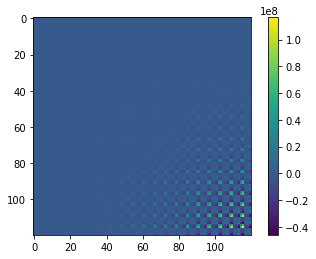

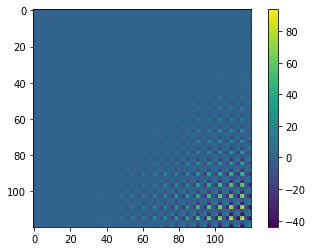

In [30]:
plt.imshow(dcovdBetaIa)
plt.colorbar() 
plt.show() 

plt.imshow(dcovdx0)
plt.colorbar()
plt.show() 

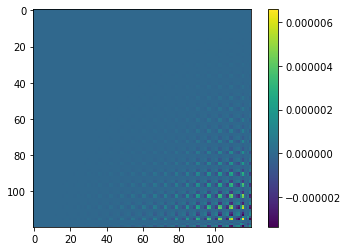

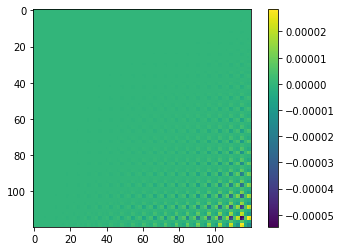

In [31]:
plt.imshow((dcovdp_fd-dcovdBetaIa)/np.linalg.norm(dcovdp_fd))
plt.colorbar() 
plt.show() 

plt.imshow((dcovdx0_fd-dcovdx0)/np.linalg.norm(dcovdx0_fd))
plt.colorbar() 
plt.show() 

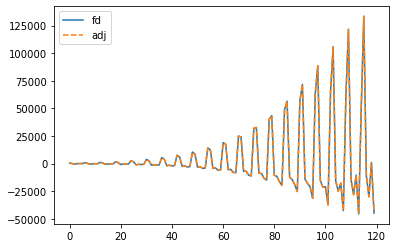

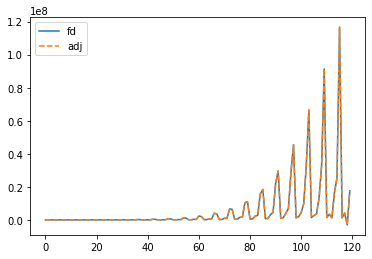

In [32]:
# Check fd and adj computation for parameter derivatives 
plt.plot(dcovdp_fd[0], label='fd')
plt.plot(dcovdBetaIa[0], '--', label='adj')
plt.legend() 
plt.show() 

plt.plot(np.diag(dcovdp_fd), label='fd')
plt.plot(np.diag(dcovdBetaIa), '--', label='adj')
plt.legend() 
plt.show() 

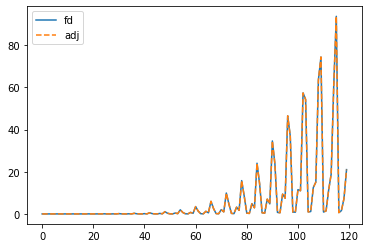

In [33]:
# Check fd and adj computation for x0 derivatives 
plt.plot(np.diag(dcovdx0_fd), label='fd')
plt.plot(np.diag(dcovdx0), '--', label='adj')
plt.legend() 
plt.show() 

## Check d(-logp)/dp

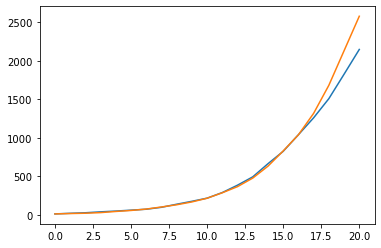

In [34]:
# Make up some obs and fltr 
t2 = 20 
Nf = 20+1
model = pyross.stochastic.Spp(model_spec, inference_parameters, M, Ni)
data = model.simulate(x0, contactMatrix, t2, Nf)
x = (data['X']).astype('float') 

plt.plot(x[:, -2:])
plt.show()

In [45]:
fltr = np.kron([0, 0, 1],np.identity(M))
obs=np.einsum('ij,kj->ki', fltr, x)
fltr_list, obs_flattened, obs0 = pyross.utils.process_latent_data(fltr, obs)
fltr_list = fltr_list[1:]

CM_derivative=False
dx0 = np.identity((M*nClass))[[0], :]
dp = np.ones((1, 2))

inference_parameters['betaIa'] = beta*alpha

estimator.set_params(inference_parameters)
estimator.set_det_model(inference_parameters)
estimator.lambdify_derivative_functions(['betaIa'], CM_derivative)

start_time = time.time()
minuslogp, dminuslogp = estimator._minuslogp_and_grad(x0, obs_flattened, fltr_list, t2, dx0, dp)
end_time = time.time() 
print(end_time-start_time)
print(dminuslogp.shape, dminuslogp[0], minuslogp)

Looking for saved derivative functions...
Loaded.
0.10597896575927734
(2,) 1209.5087434568181 143.7053268917667


In [36]:
lower = beta*alpha - 0.01
upper = beta*alpha + 0.01
n_samples = 10
f = np.empty(n_samples)
df = np.empty(n_samples)
for (i, betaIa) in enumerate(np.linspace(lower, upper, n_samples)): 
    inference_parameters['betaIa'] = betaIa
    estimator.set_params(inference_parameters)
    estimator.set_det_model(inference_parameters)
    f[i], temp = estimator._minuslogp_and_grad(x0, obs_flattened, fltr_list, t2, dx0,dp)
    df[i] = temp[0]

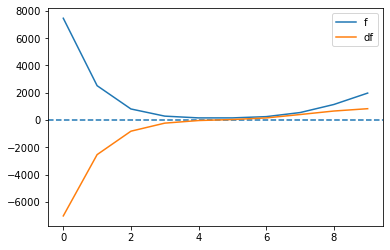

In [37]:
plt.axhline(ls='--')
plt.plot(f, label='f')
plt.plot(df/500, label='df')
plt.legend()
plt.show() 

In [38]:
def dlogpdp_FD(param_str, scale=1e6):
    Paramvalue = inference_parameters[param_str]
    dp = Paramvalue/scale
    
    inference_parameters[param_str] += dp
    minuslogp_p = estimator.minus_logp_red(inference_parameters, x0, obs, fltr, t2, contactMatrix, tangent=True)
    print(minuslogp_p)

    inference_parameters[param_str] -= 2*dp
    minuslogp_m = estimator.minus_logp_red(inference_parameters, x0, obs, fltr, t2, contactMatrix, tangent=True)
    print(minuslogp_m)

    inference_parameters[param_str] +=dp
    return (minuslogp_p-minuslogp_m)/(2*dp)  

start_time = time.time()
inference_parameters['betaIa'] = beta*alpha
dminuslogp_FD = dlogpdp_FD('betaIa', scale=1e6)
end_time = time.time() 
print(dminuslogp_FD)
print((end_time - start_time)/2)

143.70533199347136
143.70532179033032
1212.5684722197836
0.017362475395202637


In [39]:
(dminuslogp[0]-dminuslogp_FD)/dminuslogp_FD

-0.002523345141379295